In [1]:
import sys, os
import argparse
import re
import time
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import cycler
from sklearn.metrics import r2_score
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
import imblearn

## Read in cell type compositions from best deconvolution and fga information
- read in BayesPrism top 100DEGs deconvolution cell type fractions
- read in fga data table extracted from Kari's plots

In [2]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
res_prevail

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample
TCGA-BB-4224-01A,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01
TCGA-H7-7774-01A,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01
TCGA-CV-6943-01A,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01
TCGA-CN-5374-01A,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01
TCGA-CQ-6227-01A,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CV-7235-01A,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01
TCGA-CX-7086-01A,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01
TCGA-CV-6935-11A,1.406815e-04,1.252411e-06,0.025322,0.012222,0.019459,0.000512,1.774254e-05,8.328643e-02,0.001632,0.857408,TCGA-CV-6935-11
TCGA-P3-A6SW-01A,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01


In [3]:
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
fga_Kari

,sample,fga
0,TCGA-CR-7391-01,0.617
1,TCGA-CN-6995-01,0.712
2,TCGA-CQ-A4C6-01,0.354
3,TCGA-CV-A6K0-01,0.676
4,TCGA-CR-6471-01,0.134
...,...,...
519,TCGA-CN-4725-01,0.576
520,TCGA-CV-7440-01,0.635
521,TCGA-CN-4726-01,0.298
522,TCGA-CN-A6V6-01,0.442


In [4]:
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari

In [5]:
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
# Merging fga + cell type fractions 

### Merge fga + cell type fractions and add FGA status with cutoff 0.2

In [6]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)

In [7]:
df_merged

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526,High
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent
3,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572,High
4,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,0.26,0.650,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6.054611e-03,1.846723e-06,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736,High
480,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778,High
481,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642,High
482,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,0.28,0.545,High


### Get concensus HPV positive sample annotations from Nulton et al. 2017 and official TCGA GDC phenodata

In [8]:
Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
Nulton

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,HNSCC Barcode,Type
0,TCGA-HD-A634,HPV16
1,TCGA-P3-A5QE,HPV16
2,TCGA-BA-A4IH,HPV16
3,TCGA-BB-7866,HPV16
4,TCGA-DQ-7596,HPV16
...,...,...
67,TCGA-CV-6939,HPV33
68,TCGA-DQ-7591,HPV35
69,TCGA-IQ-A61I,HPV35
70,TCGA-HD-8314,HPV35


In [11]:
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Negative') & (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
TCGA_pheno['hpv_status'].value_counts()

            510
Negative     57
Positive     45
Name: hpv_status, dtype: int64

In [13]:
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]

In [14]:
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()

In [19]:
# remove conflict samples between TCGA annotation and Nulton et al.
list_remove = []
for i in list_pos_tcgaPheno:
    if i not in list_pos_Nulton:
        list_remove.append(i)
list_remove

['TCGA-CN-A640',
 'TCGA-CN-A641',
 'TCGA-QK-A8ZA',
 'TCGA-DQ-7595',
 'TCGA-QK-AA3K',
 'TCGA-BB-7872',
 'TCGA-BA-A6DA',
 'TCGA-CN-A63Y',
 'TCGA-BA-A6DF',
 'TCGA-CN-A6V1']

In [24]:
set_pos = list_pos_Nulton
print("We gathered",len(list_pos_Nulton),"Positive samples from two source") 
print("We removed",len(list_remove),"conflicting samples") 

We gathered 72 Positive samples from two source
We removed 10 conflicting samples


## Read in anatomical sites and sample type data 

In [52]:
TCGA_pheno['sample_type.samples'].value_counts()
# Select only primary tumor

Primary Tumor          528
Solid Tissue Normal     82
Metastatic               2
Name: sample_type.samples, dtype: int64

In [53]:
# All TCGA annotated primary sites, merge to 4 major sites
TCGA_pheno['primary_site'].value_counts()

Other and unspecified parts of tongue                                   158
Larynx                                                                  144
Other and ill-defined sites in lip, oral cavity and pharynx              90
Floor of mouth                                                           62
Tonsil                                                                   47
Other and unspecified parts of mouth                                     44
Base of tongue                                                           27
Gum                                                                      11
Oropharynx                                                               10
Hypopharynx                                                               9
Palate                                                                    6
Lip                                                                       3
Bones, joints and articular cartilage of other and unspecified sites      1
Name: primar

In [54]:
dict_primary_site = {'Alveolar Ridge': 'Oral Cavity',
 'Floor of mouth': 'Oral Cavity',
 'Palate': 'Oral Cavity',
 'Lip': 'Oral Cavity',
 'Oral Tongue': 'Oral Cavity',
 'Oral Cavity': 'Oral Cavity',
 'Other and unspecified parts of tongue': 'Oral Cavity',
 'Other and unspecified parts of mouth': 'Oral Cavity',
 'Base of tongue': 'Oropharynx',
 'Tonsil': 'Oropharynx',
 'Oropharynx': 'Oropharynx',
    'Larynx': 'Larynx',    
    'Floor of mouth':'Oral Cavity',
    'Gum':'Oral Cavity',
    'Oropharynx':'Oropharynx',
    'Hypopharynx':'Hypopharynx',}

In [55]:
TCGA_pheno_new = TCGA_pheno.copy()
TCGA_pheno_new['primary_site'] = TCGA_pheno_new['primary_site'].map(dict_primary_site)
TCGA_pheno_new.dropna(subset='primary_site',inplace=True)

#Selecting only primary tumor!
TCGA_pheno_new = TCGA_pheno_new[TCGA_pheno_new['sample_type.samples']=='Primary Tumor']
TCGA_pheno_new['primary_site'].value_counts()

Oral Cavity    250
Larynx         117
Oropharynx      80
Hypopharynx      9
Name: primary_site, dtype: int64

In [60]:
df_merged['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]

df_merged_sites = pd.merge(df_merged,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
df_merged_sites

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample_x,cellularity,fga,FGA_status,sample_match,sample_y,primary_site
0,2.411960e-06,0.000008,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526,High,TCGA-BB-4224,TCGA-BB-4224,Oral Cavity
1,3.293064e-03,0.001012,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent,TCGA-CV-6943,TCGA-CV-6943,Oropharynx
2,5.709435e-03,0.003259,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572,High,TCGA-CN-5374,TCGA-CN-5374,Oropharynx
3,9.027032e-04,0.000002,0.071847,0.081868,0.050790,0.000264,1.089332e-01,1.467499e-06,0.004751,0.680641,TCGA-CV-6959-01,0.36,0.430,High,TCGA-CV-6959,TCGA-CV-6959,Oral Cavity
4,5.913925e-04,0.000002,0.020984,0.029199,0.007936,0.000043,4.149415e-02,1.773275e-02,0.005312,0.876706,TCGA-F7-A61V-01,0.60,0.192,Silent,TCGA-F7-A61V,TCGA-F7-A61V,Oropharynx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,6.054611e-03,0.000002,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736,High,TCGA-CN-6010,TCGA-CN-6010,Larynx
410,2.447322e-07,0.000006,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity
411,1.076841e-03,0.000132,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642,High,TCGA-CX-7086,TCGA-CX-7086,Oral Cavity
412,2.015405e-02,0.001774,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,0.28,0.545,High,TCGA-P3-A6SW,TCGA-P3-A6SW,Oropharynx


### Create merged data table for HPV pos and neg groups

In [95]:
df_merged_HPVpos = df_merged_sites.copy()
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
df_merged_HPVpos['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos.shape[0])

58


In [96]:
df_merged_HPVneg = df_merged_sites.copy()
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos) & ~df_merged_HPVneg['sample_match'].isin(list_remove)]
df_merged_HPVneg['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg.shape[0])

352


### Get relative immune cell type fractions as a function of nun-malignant cells


In [97]:
df_merged_HPVpos_relative = df_merged_HPVpos.copy()
df_merged_HPVpos_relative.iloc[:,:9] = df_merged_HPVpos_relative.iloc[:,:9].div(df_merged_HPVpos_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVpos_relative

In [98]:
df_merged_HPVneg_relative = df_merged_HPVneg.copy()
df_merged_HPVneg_relative.iloc[:,:9] = df_merged_HPVneg_relative.iloc[:,:9].div(df_merged_HPVneg_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_relative

In [99]:
df_merged_relative = pd.concat([df_merged_HPVpos_relative,df_merged_HPVneg_relative])
df_merged_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample_x,cellularity,fga,FGA_status,sample_match,sample_y,primary_site,hpv_status
2,3.409167e-02,0.019462,0.222862,0.161270,0.314196,0.004043,7.262752e-02,0.000013,0.171435,0.832527,TCGA-CN-5374-01,0.36,0.572,High,TCGA-CN-5374,TCGA-CN-5374,Oropharynx,Positive
6,3.390862e-02,0.020294,0.223260,0.212812,0.371574,0.005759,3.879069e-06,0.000006,0.132382,0.762338,TCGA-CR-5249-01,0.48,0.098,Silent,TCGA-CR-5249,TCGA-CR-5249,Oropharynx,Positive
24,1.130509e-02,0.138588,0.135500,0.046241,0.527160,0.000541,2.256308e-03,0.000005,0.138403,0.699535,TCGA-CV-6433-01,0.66,0.245,High,TCGA-CV-6433,TCGA-CV-6433,Oral Cavity,Positive
33,1.720701e-02,0.006089,0.044510,0.553364,0.339695,0.001231,1.766793e-06,0.000002,0.037900,0.453513,TCGA-H7-A76A-01,0.27,0.436,High,TCGA-H7-A76A,TCGA-H7-A76A,Oropharynx,Positive
41,3.486226e-02,0.152736,0.192133,0.172434,0.309480,0.000268,1.697303e-02,0.000006,0.121106,0.685345,TCGA-BB-4225-01,0.56,0.542,High,TCGA-BB-4225,TCGA-BB-4225,Oropharynx,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,7.418559e-04,0.000275,0.312844,0.346991,0.158302,0.001420,1.326142e-01,0.005582,0.041229,0.942446,TCGA-C9-A47Z-01,0.63,0.562,High,TCGA-C9-A47Z,TCGA-C9-A47Z,Oral Cavity,Negative
409,1.491043e-02,0.000005,0.154127,0.236060,0.108300,0.001571,1.296746e-03,0.481765,0.001965,0.593934,TCGA-CN-6010-01,0.36,0.736,High,TCGA-CN-6010,TCGA-CN-6010,Larynx,Negative
410,5.454056e-07,0.000013,0.104302,0.759402,0.117746,0.000915,6.073761e-07,0.000001,0.017620,0.551284,TCGA-CV-7235-01,0.40,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity,Negative
411,1.467926e-02,0.001796,0.430551,0.276839,0.176143,0.000974,5.125722e-03,0.005153,0.088738,0.926642,TCGA-CX-7086-01,0.61,0.642,High,TCGA-CX-7086,TCGA-CX-7086,Oral Cavity,Negative


## Dataset explamatory analysis

<AxesSubplot:>

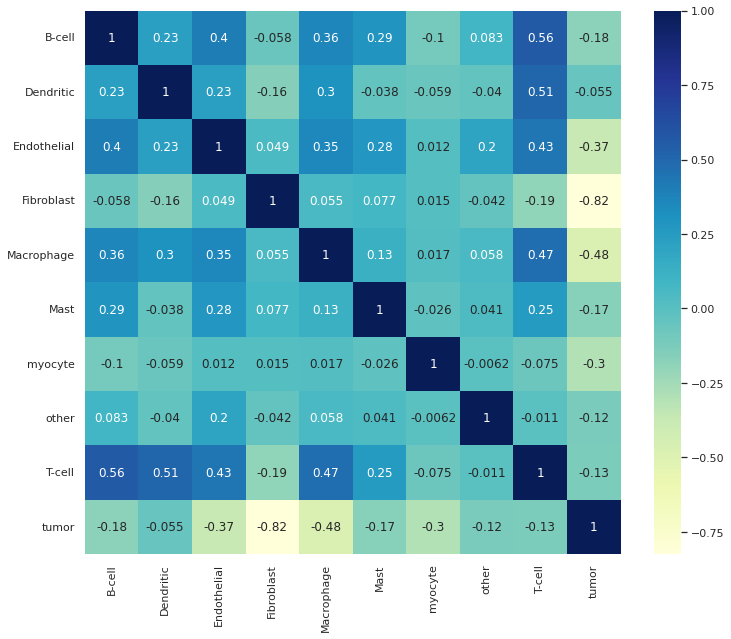

In [89]:
# cell type fractions correlations heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(df_merged.iloc[:,:10].corr(),cmap="YlGnBu",annot=True,)

Text(0.5, 1.0, 'Deconvolved TCGA samples FGA distribution')

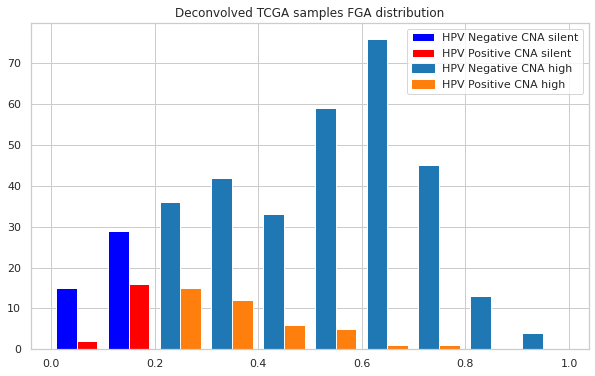

In [384]:
fig, ax = plt.subplots(figsize=(10, 6))
data_distribution = [df_merged_relative[df_merged_relative['hpv_status']=='Negative']['fga'].to_numpy(),df_merged_relative[df_merged_relative['hpv_status']=='Positive']['fga'].to_numpy()]
N, bins, patches = ax.hist(data_distribution,bins=10,label=['HPV Negative','HPV Positive'],color=['tab:blue','tab:orange'])
# ax = df_merged_relative.plot(kind='hist',column='fga',by='hpv_status',figsize=(10, 8),cumulative=True,
#                         title=['HPV negative sample FGA distribution','HPV positive sample FGA distribution'],sharex=True)

patches[0][0].set_facecolor('blue')
patches[0][1].set_facecolor('blue')
patches[1][0].set_facecolor('red')
patches[1][1].set_facecolor('red')

ax.legend(['HPV Negative CNA silent','HPV Positive CNA silent','HPV Negative CNA high','HPV Positive CNA high'])
leg = ax.get_legend()
leg.legendHandles[2].set_color('tab:blue')
leg.legendHandles[3].set_color('tab:orange')

ax.set_title('Deconvolved TCGA samples FGA distribution')

In [227]:
group_HPVneg = pd.DataFrame(df_merged_HPVneg_relative.groupby('FGA_status')['primary_site'].value_counts(sort=False))
group_HPVneg['label'] = [i[1] for i in group_HPVneg.index]
group_HPVneg = group_HPVneg.sort_values(['FGA_status','label'])
group_HPVneg

primary_site        label
FGA_status primary_site                           
High       Hypopharynx              6  Hypopharynx
           Larynx                  99       Larynx
           Oral Cavity            182  Oral Cavity
           Oropharynx              21   Oropharynx
Silent     Hypopharynx              1  Hypopharynx
           Larynx                   5       Larynx
           Oral Cavity             36  Oral Cavity
           Oropharynx               2   Oropharynx

### From which anatomical sites are the HPV-negative CNA-silent cases? 
> How many oral cavity, how many hypopharynx etc? Make a table of the silent cases and which anatomical locations they are. 

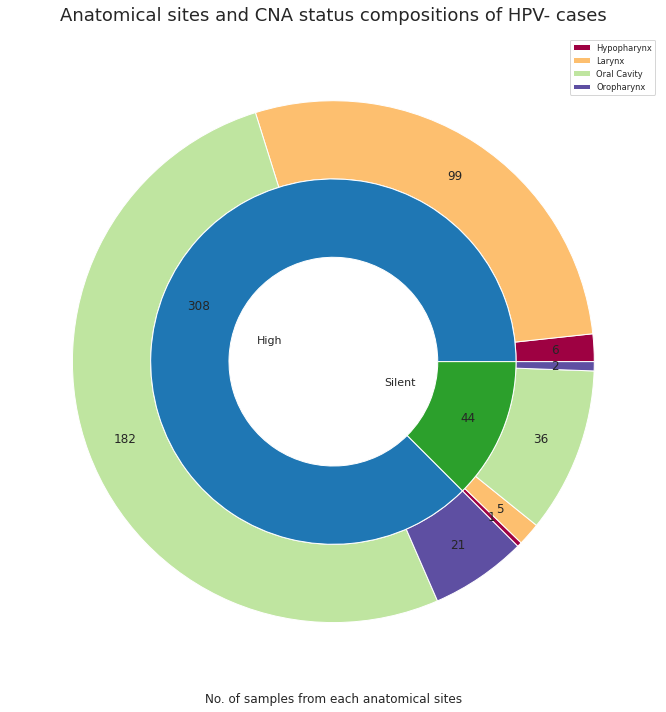

In [256]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Anatomical sites and CNA status compositions of HPV- cases', fontsize=18, pad=15)

size = 0.3
# colors = ['dimgrey', 'lightcoral','chocolate','darkorange' ]
colors_CNA = ['tab:blue','tab:green']

colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, 4)]
ax.set_prop_cycle('color', colors)
ax.pie(group_HPVneg['primary_site'],radius=1,wedgeprops=dict(width=size,edgecolor='w'),colors = colors,
           autopct=lambda x: '{:.0f}'.format(x*group_HPVneg['primary_site'].sum()/100),pctdistance=0.85,
      )

ax.pie(group_HPVneg.groupby('FGA_status')['primary_site'].sum(),radius=1-size,wedgeprops=dict(width=size,edgecolor='w'),
       labels = df_merged_HPVneg_relative['FGA_status'].value_counts(sort=False).index.tolist(),autopct=lambda x: '{:.0f}'.format(x*df_merged_HPVneg_relative['FGA_status'].value_counts().sum()/100),
      pctdistance=0.80,labeldistance = 0.3,colors = colors_CNA)

ax.legend(group_HPVneg['label'].value_counts().index,fontsize='x-small')
ax.set_xlabel("No. of samples from each anatomical sites")
plt.show()

Text(0.5, 1.0, 'Anatomical sites of HPV- CNA silent cases')

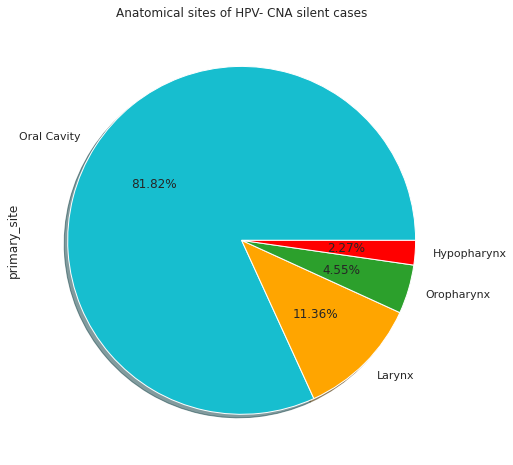

In [223]:
statistic_hpvneg_silent = df_merged_HPVneg_relative[df_merged_HPVneg_relative['FGA_status']=='Silent']['primary_site']
ax = statistic_hpvneg_silent.value_counts().plot(kind='pie',autopct=lambda x: '{:.2f}%'.format(x),figsize=(8, 8),shadow=True,colors=['tab:cyan','orange','tab:green','red'])
ax.set_title('Anatomical sites of HPV- CNA silent cases')

In [257]:
group_HPVpos = pd.DataFrame(df_merged_HPVpos_relative.groupby('FGA_status')['primary_site'].value_counts(sort=False))
group_HPVpos['label'] = [i[1] for i in group_HPVpos.index]
group_HPVpos = group_HPVpos.sort_values(['FGA_status','label'])
group_HPVpos

primary_site        label
FGA_status primary_site                           
High       Hypopharynx              1  Hypopharynx
           Oral Cavity              7  Oral Cavity
           Oropharynx              32   Oropharynx
Silent     Hypopharynx              1  Hypopharynx
           Larynx                   1       Larynx
           Oral Cavity              2  Oral Cavity
           Oropharynx              14   Oropharynx

###  How much HPV-positive cases do we have? 
### From which anatomical site are they (we expect only oropharynx)? 
> Make a table. Also, just out of curiosity, what is the FGA for these tumors? 

In [260]:
print("We gathered",len(set_pos),"Positive samples from two source") 

We gathered 72 Positive samples from two source


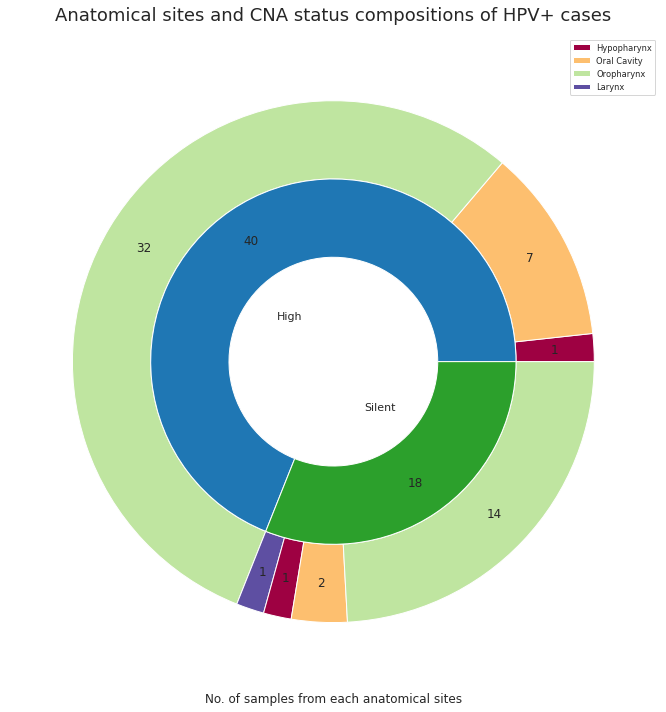

In [259]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Anatomical sites and CNA status compositions of HPV+ cases', fontsize=18, pad=15)

size = 0.3
# colors = ['dimgrey', 'lightcoral','chocolate','darkorange' ]
colors_CNA = ['tab:blue','tab:green']

colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, 4)]
ax.set_prop_cycle('color', colors)
ax.pie(group_HPVpos['primary_site'],radius=1,wedgeprops=dict(width=size,edgecolor='w'),colors = colors,
           autopct=lambda x: '{:.0f}'.format(x*group_HPVpos['primary_site'].sum()/100),pctdistance=0.85,
      )

ax.pie(group_HPVpos.groupby('FGA_status')['primary_site'].sum(),radius=1-size,wedgeprops=dict(width=size,edgecolor='w'),
       labels = df_merged_HPVpos_relative['FGA_status'].value_counts(sort=False).index.tolist(),autopct=lambda x: '{:.0f}'.format(x*df_merged_HPVpos_relative['FGA_status'].value_counts().sum()/100),
      pctdistance=0.80,labeldistance = 0.3,colors = colors_CNA)

ax.legend(group_HPVpos['label'].value_counts().index,fontsize='x-small')
ax.set_xlabel("No. of samples from each anatomical sites")
plt.show()

Text(0.5, 1.0, 'Anatomical sites of HPV+ cases')

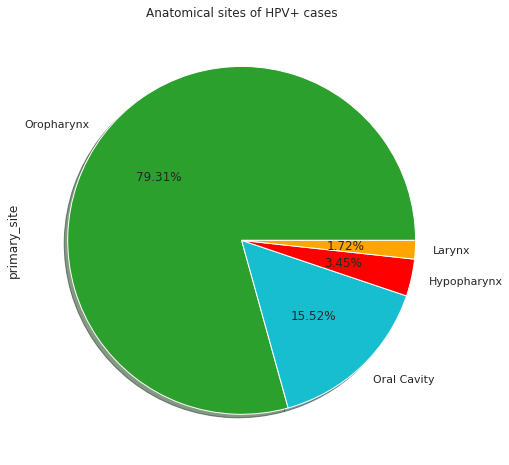

In [222]:
statistic_hpvpos = df_merged_HPVpos_relative['primary_site']
ax = statistic_hpvpos.value_counts().plot(kind='pie',autopct=lambda x: '{:.2f}%'.format(x),figsize=(8, 8),shadow=True,colors=['tab:green','tab:cyan','red','orange'])
ax.set_title('Anatomical sites of HPV+ cases')

### Compare cell type compositions between samples with two CNA status 
- Copy number alteration groups, all cell types (CNA-silent, nonsilent with cut-off FGA 0.20)
- HPV-, all Oral cavity

In [113]:
print("Number of CNA-high and CNA-silent samples that are also HPV-")
df_merged_HPVneg['FGA_status'].value_counts()

Number of CNA-high and CNA-silent samples that are also HPV-


High      308
Silent     44
Name: FGA_status, dtype: int64

In [102]:
# comparison of CNA-silent vs –high of only oral cavity tumors. 
# This is a ‘’cleaner’’ comparison since anatomical site wouldn’t influence the results now, only looking at difference between silent and nonsilent in oral cavity. 
df_merged_HPVneg_fga_site_relative_OC = df_merged_HPVneg_relative[df_merged_HPVneg_relative['primary_site']=='Oral Cavity']

In [103]:
df_merged_HPVneg_melt = pd.melt(df_merged_HPVneg_fga_site_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
df_merged_HPVneg_melt

,FGA_status,variable,value
0,High,B-cell,0.000027
1,High,B-cell,0.002827
2,High,B-cell,0.046388
3,Silent,B-cell,0.000070
4,High,B-cell,0.000222
...,...,...,...
2175,High,tumor,0.508952
2176,High,tumor,0.942446
2177,High,tumor,0.551284
2178,High,tumor,0.926642


Text(0, 0.5, 'Cell type fractions')

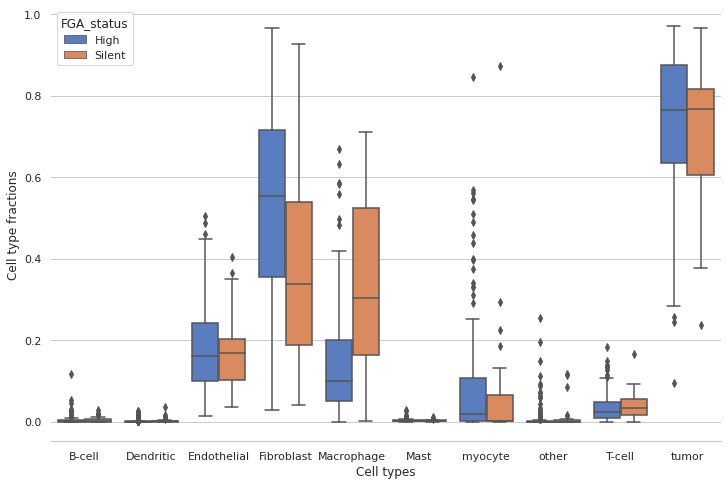

In [104]:
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Immune cells only

In [399]:
df_merged_HPVneg_immune_relative = df_merged_HPVneg.copy()[['B-cell','Dendritic','Macrophage','Mast','T-cell','fga','FGA_status','sample_match','primary_site','hpv_status']]
df_merged_HPVneg_immune_relative.iloc[:,:5] = df_merged_HPVneg_immune_relative.iloc[:,:5].div(df_merged_HPVneg_immune_relative.iloc[:,:5].sum(axis=1),axis=0)
# df_merged_HPVneg_immune_relative

In [400]:
df_merged_HPVneg_immune_relative_OC = df_merged_HPVneg_immune_relative[df_merged_HPVneg_immune_relative['primary_site']=='Oral Cavity']
df_merged_HPVneg_immune_melt = pd.melt(df_merged_HPVneg_immune_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_immune_relative_OC.columns[:5].tolist())
df_merged_HPVneg_immune_melt

,FGA_status,variable,value
0,High,B-cell,0.000072
1,High,B-cell,0.015918
2,High,B-cell,0.361085
3,Silent,B-cell,0.000104
4,High,B-cell,0.001220
...,...,...,...
1085,High,T-cell,0.189396
1086,High,T-cell,0.204138
1087,High,T-cell,0.129280
1088,High,T-cell,0.314306


Text(0, 0.5, 'Cell type fractions')

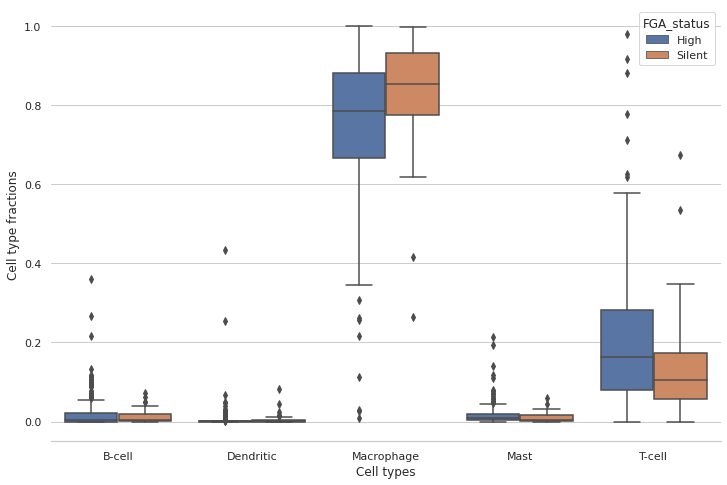

In [401]:
#
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_immune_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Visualizations below requires resampling to alleviate the effect of class-imbalance!
#### We do not wish to lose any valuable CNA-high samples, therefore use SMOTE (Synthetic Minority Oversampling) algorithm to upsample CNA silent group, as a result we have equal number of CNA-high and silent samples

In [106]:
sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist()
list_col.append('fga')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_fga_site_relative_OC.loc[:,list_col].to_numpy(),df_merged_HPVneg_fga_site_relative_OC['FGA_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 364
High      182
Silent    182
Name: FGA_status, dtype: int64


In [107]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['FGA_status'] = y_train
# df_afterSMOTE

In [108]:
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
# df_afterSMOTE_melt

In [109]:
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

### Draw a categorical scatterplot to show each observation, cell type fractions are log transformed to speed up visualization and spread data points out

[Text(0.5, 0, 'log-transfomed Oral Cavity Cell type percentage SWARMs across CNA status after SMOTE resampling')]

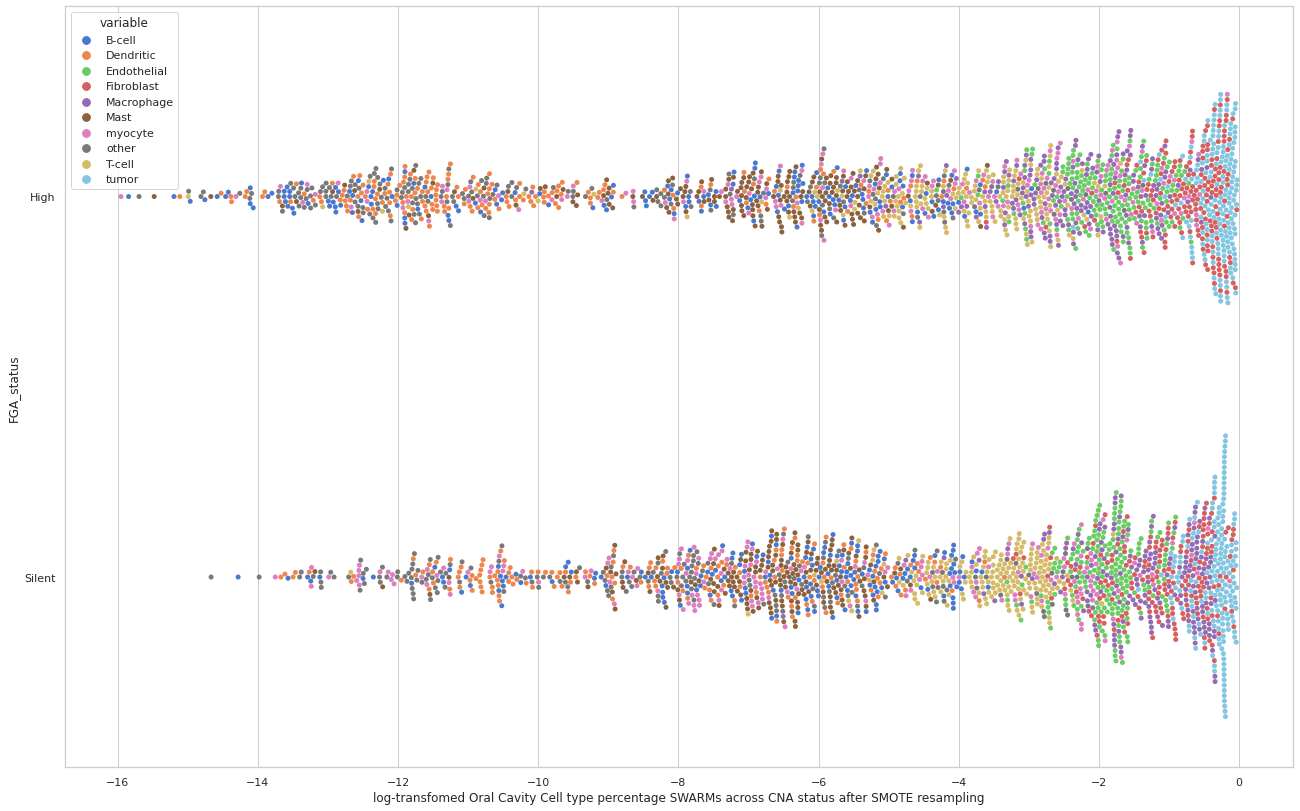

In [291]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,14))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="FGA_status", hue="variable")
ax.set(xlabel="log-transfomed Oral Cavity Cell type percentage SWARMs across CNA status after SMOTE resampling")

### Try to visualize Top Principle Component of 10 sets of cell type fractions for all samples
> Dim reduction to reduce features: 10 cell types as feature -> 1 PC as feature
 
>May help capture the hidden pattern within compositions

In [262]:
# pca and minmax scale
mmscaler = MinMaxScaler()

[0.52514002 0.2560835 ]


Text(0.5, 1.0, 'CNA-high group 2-component PCA')

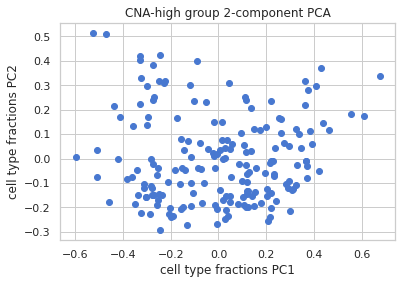

In [275]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='High'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-high group 2-component PCA")

[0.61999055 0.20161233]


Text(0.5, 1.0, 'CNA-silent group 2-component PCA')

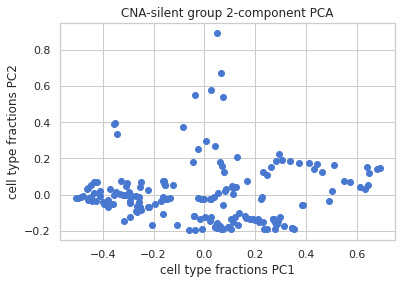

In [276]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=2)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat)[:,0],pca.transform(df_mat)[:,1])
plt.xlabel("cell type fractions PC1")
plt.ylabel("cell type fractions PC2")
plt.title("CNA-silent group 2-component PCA")

### FGA high vs silent groups: TME shown per cell type per CNA group
- x-axis: FGA
- y-axis: minmax scaled cell type fractions, upper row of sub-plots: CNA-high, lower row of sub-plots: CNA-silent
- size and color of data points: cell type fractions

> Purpose of minmax scale normalization: hard to directly compare scatterplot with two different y-axis limits (0-0.2 and 0.2-1.0)

> Problem: data shown in this plot did not undergo SMOTE resampling so the 

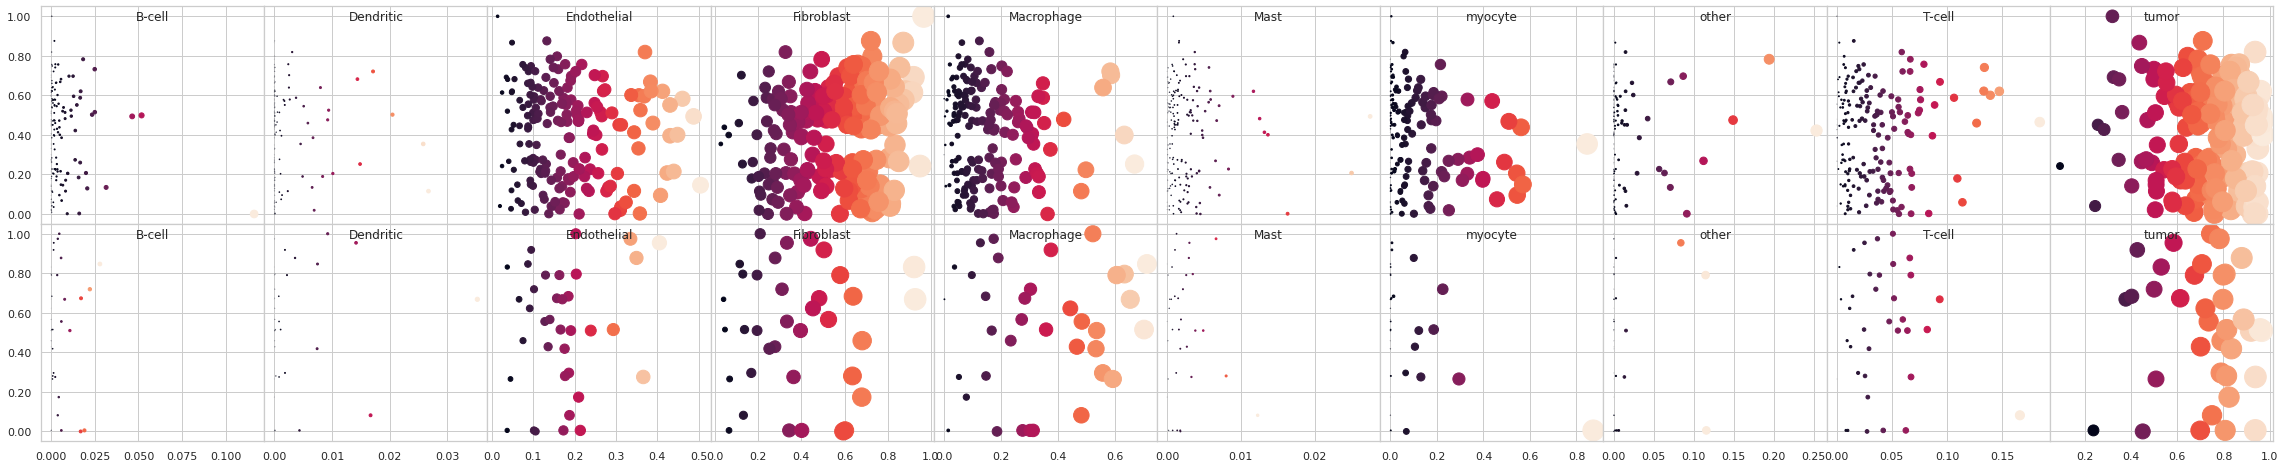

In [277]:
# Visualize fga high vs silent groups cell type compostions
fig,ax = plt.subplots(2,10,figsize=(40,8),sharey='row',sharex='col')
mmscaler = MinMaxScaler()
celltypecount = 10
count=0
for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='High']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'] # celltype fractions, non malignant relative 
    ax[0,count].scatter(z,y,c=z,s=z*500)
    ax[0,count].set_title(i,y=1.0, pad=-14)
    ax[0,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='Silent']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent']# celltype fractions, non malignant relative 
    ax[1,count].scatter(z,y,c=z,s=z*500)
    ax[1,count].set_title(i,y=1.0, pad=-14)
    ax[1,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

plt.subplots_adjust(wspace=0, hspace=0)

## Compare TME compostions between anatomical site groups

In [279]:
print("Number of HPV- samples from each anatomical sites")
df_merged_HPVneg_relative['primary_site'].value_counts()

Number of HPV- samples from each anatomical sites


Oral Cavity    218
Larynx         104
Oropharynx      23
Hypopharynx      7
Name: primary_site, dtype: int64

In [280]:
df_merged_sites_HPVneg_melt = pd.melt(df_merged_HPVneg_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_relative.columns[:10].tolist())
# df_merged_sites_HPVneg_melt

Text(0, 0.5, 'Cell type fractions')

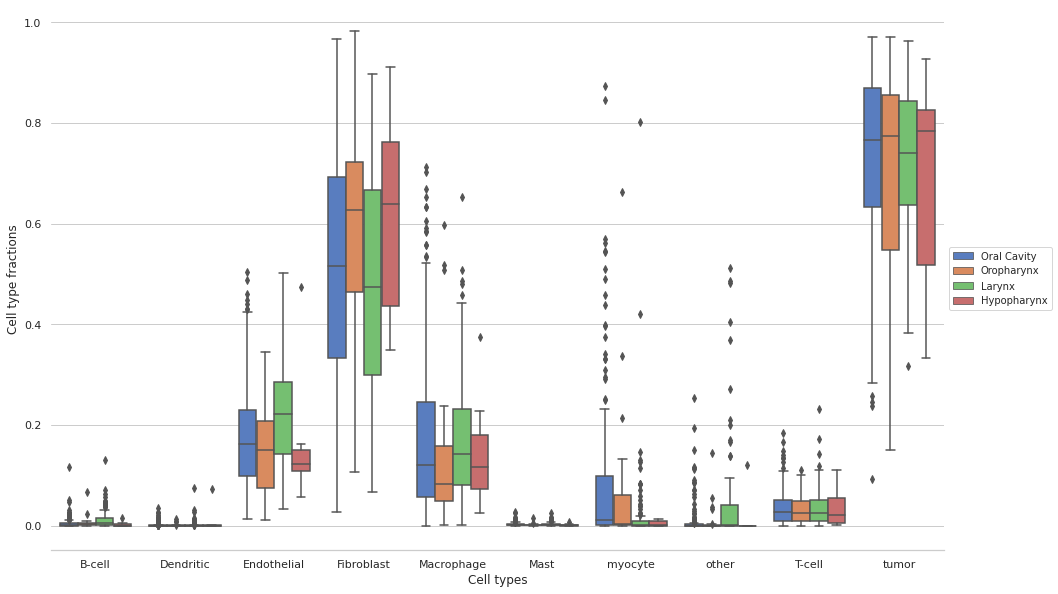

In [281]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Zoom in: Immune cells only

Text(0, 0.5, 'Cell type fractions')

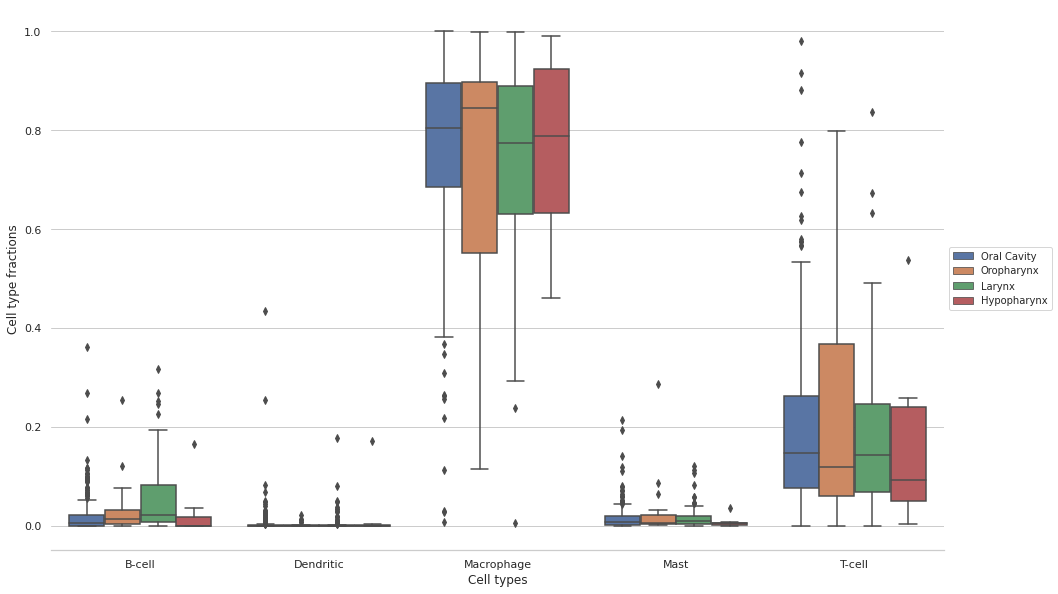

In [402]:
# Immune cells only
df_merged_HPVneg_immune_melt_sites = pd.melt(df_merged_HPVneg_immune_relative,id_vars='primary_site',value_vars=df_merged_HPVneg_immune_relative.columns[:5].tolist())
# df_merged_HPVneg_immune_melt_sites

plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_HPVneg_immune_melt_sites)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [283]:
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_relative.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_merged_HPVneg_relative.loc[:,list_col].to_numpy(),df_merged_HPVneg_relative['primary_site'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 872
Oral Cavity    218
Oropharynx     218
Larynx         218
Hypopharynx    218
Name: primary_site, dtype: int64


In [284]:
df_afterSMOTE_site = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_site['primary_site'] = y_train
# df_afterSMOTE_site

In [287]:
df_afterSMOTE_melt_site = pd.melt(df_afterSMOTE_site,id_vars='primary_site',value_vars=df_afterSMOTE_site.columns[:10].tolist())
# df_afterSMOTE_melt_site

In [288]:
df_afterSMOTE_melt_site_log = df_afterSMOTE_melt_site.copy()
df_afterSMOTE_melt_site_log['value'] = df_afterSMOTE_melt_site_log['value'].apply(np.log)

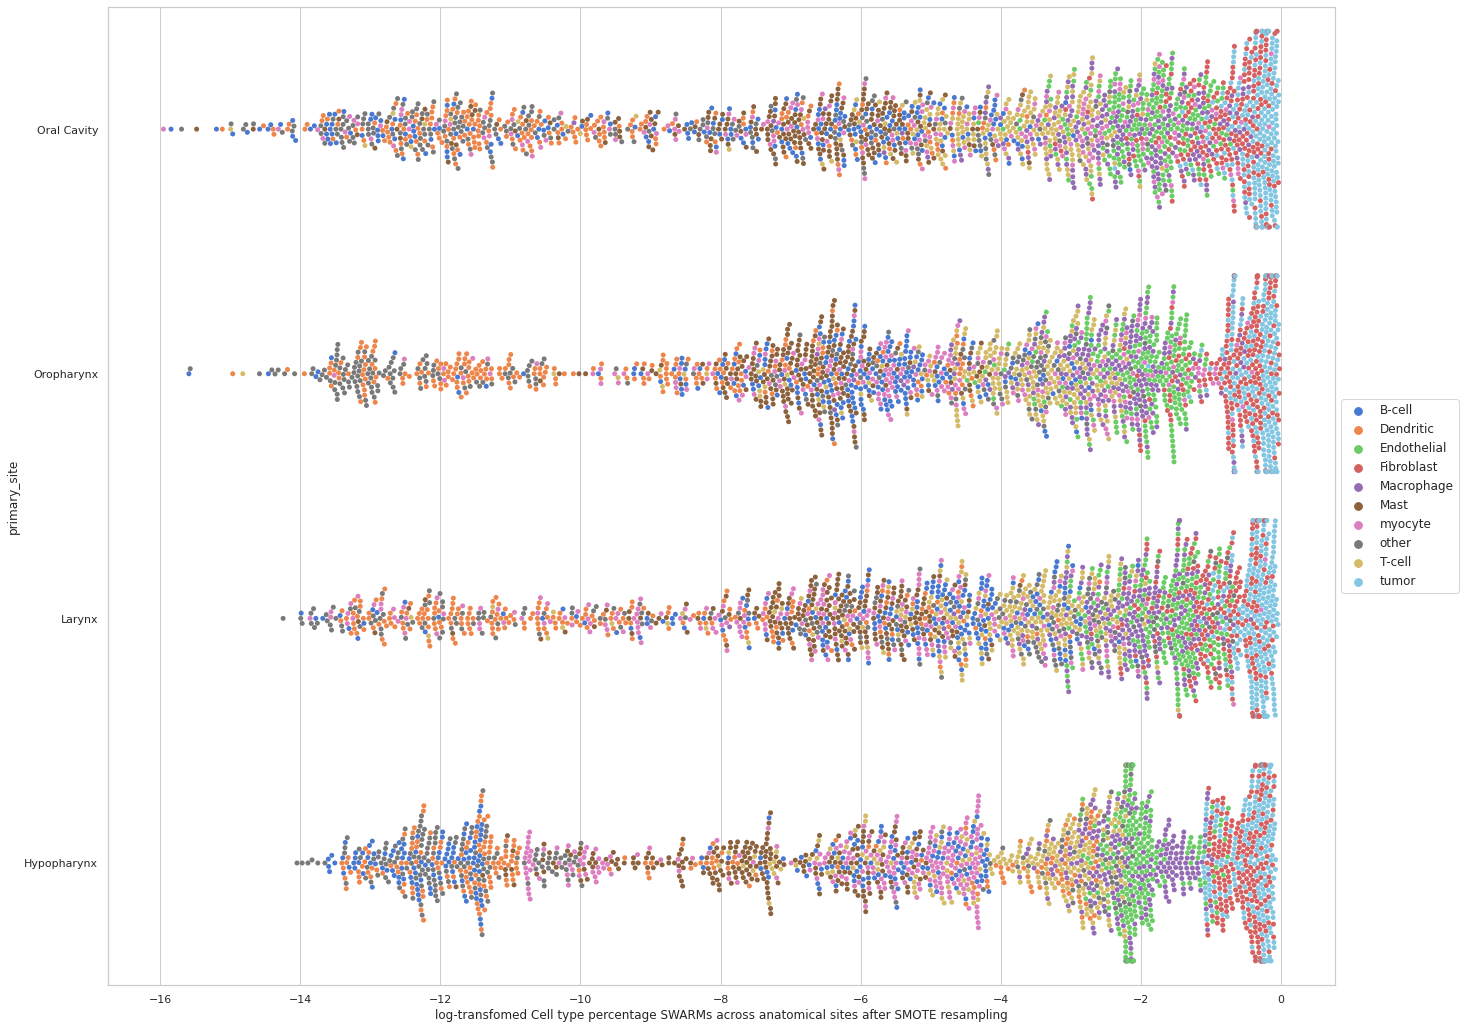

In [289]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,18))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_site_log, x="value", y="primary_site", hue="variable")
ax.set(xlabel="log-transfomed Cell type percentage SWARMs across anatomical sites after SMOTE resampling")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

[0.51636286 0.24552473]
[0.60473844 0.21303837]
[0.54764466 0.21668359]
[0.72487104 0.17208999]


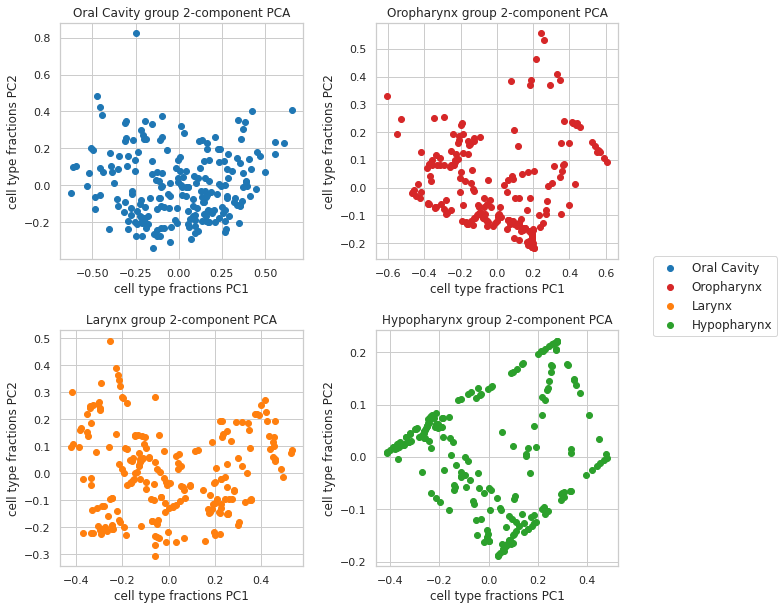

In [439]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
pic = 0
dict_color_sites = {'Oral Cavity':'tab:blue','Oropharynx':'tab:red','Larynx':'tab:orange','Hypopharynx':'tab:green'}
for i in df_afterSMOTE_site['primary_site'].unique():
    df_mat_site = df_afterSMOTE_site[df_afterSMOTE_site['primary_site']==i].drop(['primary_site'],axis=1)
    pca = PCA(n_components=2)
    pca.fit(df_mat_site)
    print(pca.explained_variance_ratio_)
    axi = ax.flatten()[pic]
    axi.scatter(pca.transform(df_mat_site)[:,0],pca.transform(df_mat_site)[:,1],c=dict_color_sites[i],label=i)
    axi.set_xlabel("cell type fractions PC1")
    axi.set_ylabel("cell type fractions PC2")
    axi.set_title(i+" group 2-component PCA")
    pic+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.legend(loc='center left', bbox_to_anchor=(0.94, 0.5),fontsize=12)

###	HPV-positive versus HPV-negative oropharynx tumors (no other anatomical sites here)
> list of Oropharynx samples identified

In [296]:
df_oro = df_merged_relative[df_merged_relative['primary_site']=='Oropharynx']

In [297]:
df_oro['hpv_status'].value_counts()

Positive    46
Negative    23
Name: hpv_status, dtype: int64

In [298]:
df_oro_melt = pd.melt(df_oro,id_vars='hpv_status',value_vars=df_oro.columns[:10].tolist())
# df_oro_melt

Text(0, 0.5, 'Cell type fractions')

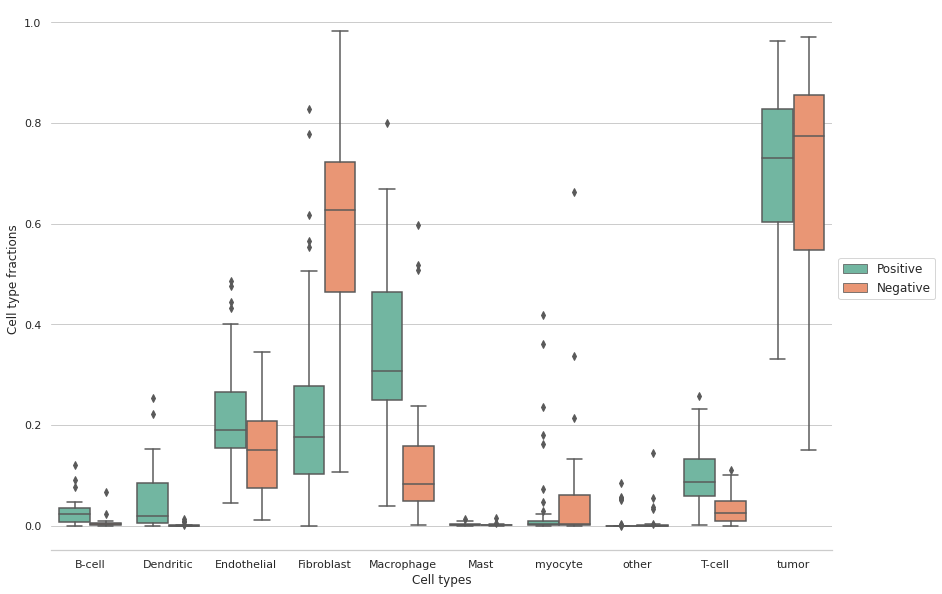

In [299]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

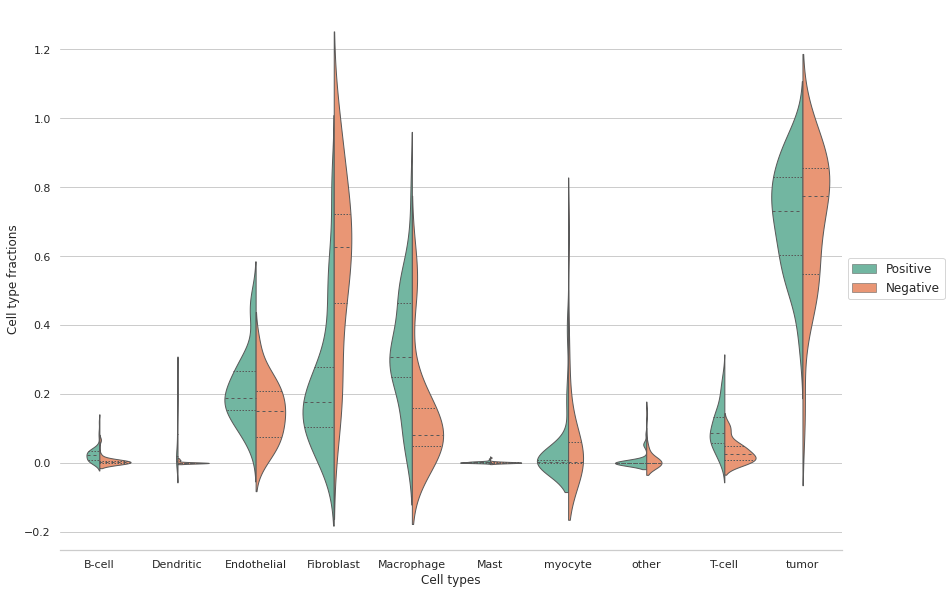

In [300]:
plt.subplots(figsize=(14,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt, inner="quart", split=True,linewidth=1,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [301]:
# try oversampling HPV status, prove SMOTE does not amplify or cause change of pattern
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_oro.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_oro.loc[:,list_col].to_numpy(),df_oro['hpv_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 92
Positive    46
Negative    46
Name: hpv_status, dtype: int64


In [302]:
df_afterSMOTE_hpv_oro = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_hpv_oro['hpv_status'] = y_train
df_afterSMOTE_hpv_oro_melt = pd.melt(df_afterSMOTE_hpv_oro,id_vars='hpv_status',value_vars=df_afterSMOTE_hpv_oro.columns[:10].tolist())
# df_afterSMOTE_melt_site

Text(0, 0.5, 'Cell type fractions')

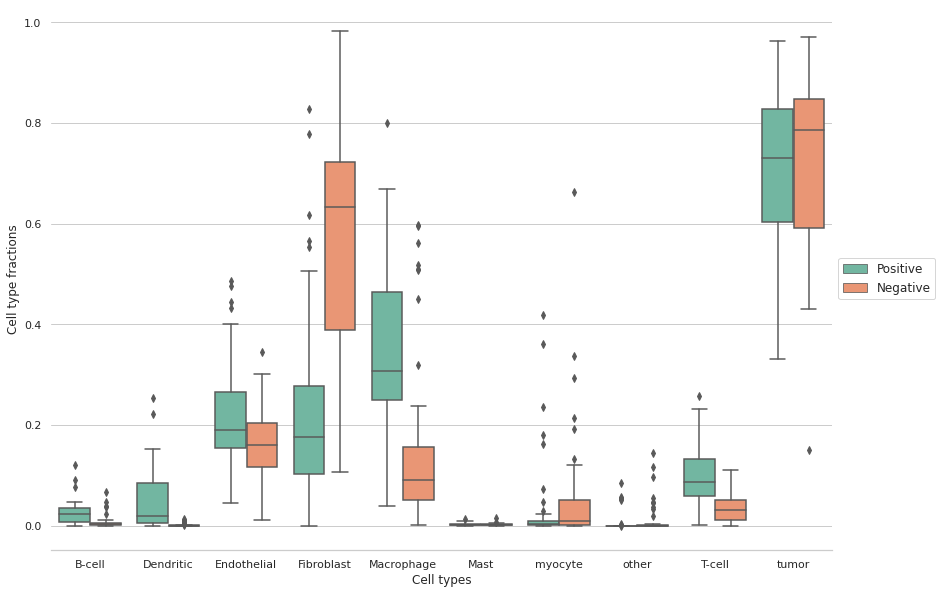

In [303]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

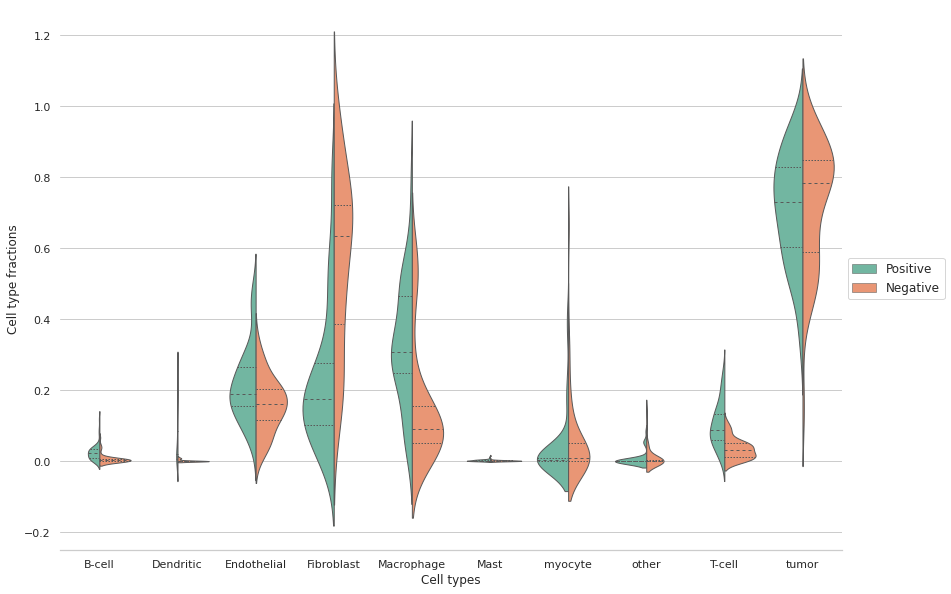

In [304]:
plt.subplots(figsize=(14,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_melt, inner="quart", split=True,linewidth=1,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")